# ML Bootcamp for experienced software engineers: Part 1 - basics

Machine Learning _creates_ remarkably effective functions.

It does so simply by taking some initial function and repeatedly applying small updates to it.

These small updates each follow a direction based on the derivative of the function.

This is called "gradient descent" and we will write the basic building blocks of gradient descent here together. Here is a preview of our goal for Part 1:

![gradient_descent](./gradient_descent.png)

## Citing Sources
I will seek to condense [Andrej Karpathy's excellent "building micrograd" talk](https://youtu.be/VMj-3S1tku0) to provide an interactive introduction to Machine Learning with Neural Network. Most of the `Value` class we'll develop comes from this excellent author.

I also recommend [3blue1brown's series on the topic](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi).

# Let's jump in and apply some pytorch!




In [1]:
"""
Here we call pytorch "backward" to compute the gradient of a simple function.
Pytorch's Autograd mechanism executes back propogration for a small step
each time you invoke it.
Eventually we will use pytorch to train complex functions into models.
However fundamentally `backward` is the building block of gradient descent and pytorch.
"""
import torch
x = torch.tensor(-0.5, requires_grad=True)
y = torch.tensor(0.8, requires_grad=True)
z = x*x + y
# Look, here it's happening!
z.backward()
print(x.grad, y.grad)

tensor(-1.) tensor(1.)


# What should you take away from this example

$ z = x^2 + y $

This is a differentiable function with inputs $x$ and $y$. 
We can compute the gradient at any point with math, with respect to each of these inputs.

$ \frac{\partial}{\partial x}(x^2 + y) = 2x $

and

$ \frac{\partial}{\partial y}(x^2 + y) = 1 $

The gradient, $(-1, 1)$ _is_ the update we need to apply to pick better $x$ and $y$ if we're starting at $(-0.5, 0.8)$

What pytorch does, is _automate this_ differentiation so we can repeatedly pick better $x$, $y$, and potentially many values.

# What to note for later
You probably noticed the `requires_grad`. We'll see this more in the future.

Some inputs have to come from your business problem and it wouldn't make sense for the model to optimize those.

For instance we might predict a user's preference for an ad as $z$, and let the model optimize $x$, but $y$ would be the age of a user.

This will become clearer with more real world models.

In [2]:
import collections
import math

from dataclasses import dataclass, field
from typing import Callable, List, Optional


@dataclass
class MyTensor:
    """
    Tensor basically means thing with values in it. We'll restrict
    ourselves to single values in our tensors for learning purposes.

    This class wraps float values, and allows us to call
    * add
    * multiply
    on these values to build up a long equation.
    Then, we can call `backward` to compute and populate the gradient
    all the way back through this graph.

    We represent parent/child relationships with edges in a graph.
    Those edges are tracked in `args`
    """
    data: float
    
    # argument Values, e.g. z = Value(3.0) * Value(2.0)
    # args = [Value(3.0), Value(2.0)]
    args: List["MyTensor"] = field(default_factory=list)

    # grad_fn is a function that _the outer function Value_ will call
    # and pass in the gradient of that function with respect to this value.
    #
    # This Value instance is `f` and the parent node is `l`.
    # 
    # Then the logical function is l(f(x, y)), and f(x, y) = x * y
    # (or it could be f(x, y) = x + y)
    # 
    # The user invoked `backward` on `l`, or even one of `l`'s parents.
    # All we need to know, is `l` called `grad_fn` and passed dl/df, in the argument, `grad`.
    # 
    # When we define `grad_fn` we need to compute loss with respect to inputs, `x`, and `y`.
    # and we need to update the `grad` field on those inputs.
    # 
    # x.grad = dl/dx = dl/df * df/dx
    # y.grad = dl/dy = dl/df * df/dy
    # 
    # if f = x * y, what are df/dx, and df/dy?
    # 
    grad_fn: Callable = lambda grad: None
    
    # This is where the gradient gets stored.
    #
    # Note that the gradient on this Value
    # is _with respect to_ some other parent Value
    # that was higher up in the math function.
    #
    # e.g. if the function is f(g(h(x, y))) and this value is h
    # then backward may have been called on f, _or g_, or even h
    # then `grad` would be df/dh, dg/dh, or dh/dh respectively.
    grad: float = 0

    def __eq__(self, o):
        """
        Two Values are equal if they have the same float.
        Also you can compare a Value to a plain float.
        """
        if isinstance(o, MyTensor):
            o = o.data
        if not isinstance(o, float):
            return False
        return math.isclose(self.data, o)

    def __add__(self, o) -> "MyTensor":
        def grad_fn(grad):
            self.grad += grad
            o.grad += grad

        # You can add a float to a tensor
        # and we'll wrap it for convenience.
        if not isinstance(o, MyTensor):
            o = MyTensor(o)

        return MyTensor(data = self.data + o.data, args=[self, o], grad_fn=grad_fn)

    def __mul__(self, o) -> "MyTensor":
        def grad_fn(grad):
            """
            we need to compute loss with respect to inputs, `x`, and `y`.

            x.grad = dl/dx = dl/df * df/dx
            y.grad = dl/dy = dl/df * df/dy

            if f = x * y, what are df/dx, and df/dy?

            """
            # raise Exception("you need to implement this")
            self.grad += grad * o.data
            o.grad += grad * self.data

        if not isinstance(o, MyTensor):
            o = MyTensor(o)
        return MyTensor(data = self.data * o.data, args=[self, o], grad_fn=grad_fn)
    
    def relu(self) -> "MyTensor":
        """
        We will need one quirky operation, a "Rectified Linear Unit".
        This will be our "non linearity":
        * which goes in between "linear" operations to increase
            out models function domain, and
        * which is still _essentially_ differentiable,

        For the surprising flexibility of neural networks with non-linearities,
        see the https://en.wikipedia.org/wiki/Universal_approximation_theorem

        If there is a competition for making simple things intimidating,
        this should be a top contender.
        ReLu is just f(x) = max(x, 0)
        """
        def grad_fn(grad):
            return max(grad, 0)
        return MyTensor(data = max(self.data, 0), args=[self], grad_fn=grad_fn)
    

    def backward(self, grad=1) -> None:
        """
        This value presumably has a graph of predecessors.
        All those predecessors need to have their grad set w.r.t this Value.
        Backward will compute grad_fn working back from the outermost Value to
        all the leaves.
        """
        # gradient with respect to myself is 1.
        # dl/dl = 1
        self.grad = 1

        queue = collections.deque([self])
        while queue:
            node = queue.popleft()
            node.grad_fn(node.grad)
            queue.extend(node.args)


In [3]:
import unittest

class TestAutoGrad(unittest.TestCase):
    """
    Run these test cases to make sure your update works
    """
    def tensor(self, x: float, **kwargs):
        # Try replacing MyTensor with torch.tensor. The results should be the same!
        # return torch.tensor(x, **kwargs)
        return MyTensor(x)

    def test_linear(self):
        self.assertEqual((self.tensor(3.0) * self.tensor(2.0) + self.tensor(5.0)), 11.0)
        self.assertNotEqual((self.tensor(3.0) * self.tensor(2.0) + self.tensor(5.0)), 12.0)
    
    def test_simple_gradient(self):
        c = self.tensor(3.0, requires_grad=True)
        x = self.tensor(5.0)
        o = c * x

        o.backward()
        self.assertEqual(c.grad, x)

    def test_our_function(self):
        x = self.tensor(-0.5, requires_grad=True)
        y = self.tensor(0.8, requires_grad=True)
        o = (x*x) + y

        o.backward()
        self.assertEqual(x.grad, -1.0)
        self.assertEqual(y.grad, 1.0)
    
    
    def test_aggregated_gradient(self):
        c = self.tensor(3.0, requires_grad=True)
        x = self.tensor(5.0)
        y = self.tensor(7.0)
        o = (c*x) + (c*y)
        o.backward()
        self.assertEqual(c.grad, (x+y))

    def test_layered(self):
        w1 = self.tensor(3.0, requires_grad=True)
        w2 = self.tensor(5.0, requires_grad=True)
        w3 = self.tensor(7.0, requires_grad=True)

        a = self.tensor(37.0)
        b = self.tensor(43.0)

        x1 = self.tensor(11.0)
        x2 = self.tensor(13.0)
        x3 = self.tensor(17.0)
        x4 = self.tensor(19.0)
        x5 = self.tensor(23.0)
        x6 = self.tensor(27.0)

        o = a * ((w1 * x1) + \
        (w2 * x2) + \
        (w3 * x3)) + \
        b * ((w1 * x4) + \
        (w2 * x5) + \
        (w3 * x6))
        
        o.backward()
        self.assertEqual(w1.grad, a*x1 + b*x4)
        self.assertEqual(w2.grad, a*x2 + b*x5)
        self.assertEqual(w3.grad, a*x3 + b*x6)


unittest.main(argv=[""], verbosity=2, exit=False)

test_aggregated_gradient (__main__.TestAutoGrad.test_aggregated_gradient) ... ok
test_layered (__main__.TestAutoGrad.test_layered) ... ok
test_linear (__main__.TestAutoGrad.test_linear) ... ok
test_our_function (__main__.TestAutoGrad.test_our_function) ... ok
test_simple_gradient (__main__.TestAutoGrad.test_simple_gradient) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.002s

OK


# Let's user MyTensor to optimize a simple function!

In [4]:
# how do we use this ability to "improve", x and y?
x, y = MyTensor(-0.5), MyTensor(0.8)

# tracking these separately will make graphing easier.
x_history, y_history, z_history = [], [], []
 
# We want to pick a small multiple of the gradient
# to keep the steps reasonable.
learn_rate = 0.05
def F(x, y):
    return x*x + y
    
for i in range(10):
    z = F(x, y)
    x_history.append(x.data)
    y_history.append(y.data)
    z_history.append(z.data)
    z.backward()
    x = MyTensor(x.data - learn_rate * x.grad)
    y = MyTensor(y.data - learn_rate * y.grad)


print(x_history)
print(y_history)
print(z_history)

[-0.5, -0.45, -0.405, -0.36450000000000005, -0.32805000000000006, -0.29524500000000004, -0.2657205, -0.23914845, -0.215233605, -0.1937102445]
[0.8, 0.75, 0.7, 0.6499999999999999, 0.5999999999999999, 0.5499999999999998, 0.49999999999999983, 0.44999999999999984, 0.39999999999999986, 0.34999999999999987]
[1.05, 0.9525, 0.864025, 0.7828602499999999, 0.7076168024999999, 0.6371696100249998, 0.5706073841202498, 0.5071919811374024, 0.4463255047212959, 0.38752365882424966]


# Check it out, the function is "learning"
By choosing small updates based on the gradient, 
our function slowly produces minimized outputs.

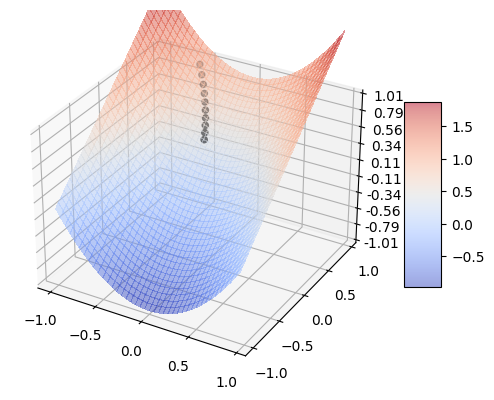

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, alpha=0.5, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.scatter(x_history, y_history, z_history, color='black', zorder=10)
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Moving on to a real Neural Network



In [6]:
"""
Gradient Descent is the real "secret sauce".
When we apply a "non-linearity" (see the comment in MyTensor.relu) we have a 
broadly applicable and differentiable function approximator!

Broadly applicable is obviously good. Differentiable means we can improve the
function using gradient descent.

Attribution:
This is basically exactly the same as:
https://github.com/karpathy/micrograd/blob/master/micrograd/nn.py
"""
import random
from typing import List

def randomized_value():
        return MyTensor(random.uniform(-1, 1))

class Module:
    """
    This just gives us the ability to reset gradients.
    """

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    
    def parameters(self) -> List[MyTensor]:
        """
        Each "Module" needs to return a list of MyTensor which
        should be included in "resetting".
        """
        raise Exception("This is expected to be implemented in Modules")


class Neuron(Module):
    def __init__(self, input_len: int):
        self.weights = [randomized_value() for _ in range(input_len)]
        self.bias = randomized_value()
    
    def __call__(self, input):
        if len(input) != len(self.weights):
            raise Exception(f"got input of length{len(input)}, expected input of length {len(self.weights)}")
        return sum((w * i for (w, i) in zip(self.weights, input)), self.bias).relu()
    
    def parameters(self) -> List[MyTensor]:
        return self.weights + [self.bias]

class Layer(Module):
    def __init__(self, num_inputs: int, num_outputs: int):
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]
    
    def __call__(self, inputs):
        return [neuron(inputs) for neuron in self.neurons]
     
    def parameters(self) -> List[MyTensor]:
        return [p for n in self.neurons for p in n.parameters()]

class MultiLayerPerceptron(Module):
    def __init__(self, input_len: int, layer_output_lens: List[int]):

        self.layers = []
        for output_len in layer_output_lens:
            self.layers.append(Layer(input_len, output_len))
            input_len = output_len

    def __call__(self, inputs):
        out = inputs
    
        for layer in self.layers:
            out = layer(out)

        return out
     
    def parameters(self) -> List[MyTensor]:
        return [p for l in self.layers for p in l.parameters()]

print(Neuron(3)([1]* 3))
print(Layer(3, 2)([1]*3))
print(MultiLayerPerceptron(3, [2, 3])([1]*3))
MultiLayerPerceptron(3, [2, 3]).zero_grad()

MyTensor(data=0, args=[MyTensor(data=-0.8529091959885089, args=[MyTensor(data=-1.6658556823963986, args=[MyTensor(data=-0.8701604234537059, args=[MyTensor(data=-0.028635317653909587, args=[], grad_fn=<function MyTensor.<lambda> at 0x17c6e0fe0>, grad=0), MyTensor(data=-0.8415251057997963, args=[MyTensor(data=-0.8415251057997963, args=[], grad_fn=<function MyTensor.<lambda> at 0x17c6e0fe0>, grad=0), MyTensor(data=1, args=[], grad_fn=<function MyTensor.<lambda> at 0x17c6e0fe0>, grad=0)], grad_fn=<function MyTensor.__mul__.<locals>.grad_fn at 0x2904f13a0>, grad=0)], grad_fn=<function MyTensor.__add__.<locals>.grad_fn at 0x2904f1c60>, grad=0), MyTensor(data=-0.7956952589426927, args=[MyTensor(data=-0.7956952589426927, args=[], grad_fn=<function MyTensor.<lambda> at 0x17c6e0fe0>, grad=0), MyTensor(data=1, args=[], grad_fn=<function MyTensor.<lambda> at 0x17c6e0fe0>, grad=0)], grad_fn=<function MyTensor.__mul__.<locals>.grad_fn at 0x2904f1d00>, grad=0)], grad_fn=<function MyTensor.__add__.<lo

# Let's now see how our MultiLayerPerceptron matches up with Pytorch

We'll follow [the pytorch quickstart tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [8]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# What is training data?
We downloaded the "fashion-mnist" dataset and it's now a file on your computer.
> Answer yourse: How big is the file?

This file is a list of input images for ML Models, and labels.
The training data is _critical_. The model will "learn" from this data.
The labels "teach" the model what good outputs look like.

> Look at https://github.com/zalandoresearch/fashion-mnist. How many different labels are there for “fashion-mnist”?

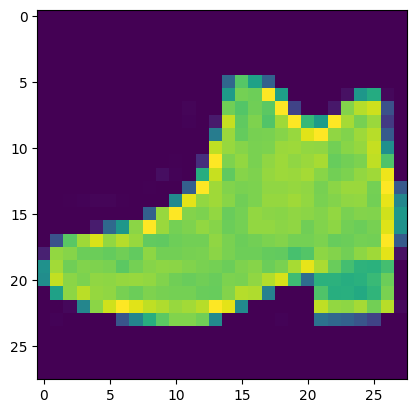

In [9]:
plt.imshow(training_data[15][0][0])

> Can you find the label for the index 15 item in the dataset?
> We displayed the image above, does it makes sense with the label?  

In [10]:
# Here's the label
training_data[15][1]

9

In [11]:
train_dataloader = DataLoader(training_data)
test_dataloader = DataLoader(test_data)

# It's pretty common to literally iterate through the dataset.
# Typically it's done in "batches" to take advantage of compute parallelism.

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) 

# Writing a "real" pytorch model!

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        """
        You saw that the images are 28x28 arrays.
        So we need to call `flatten` to produce a (28*28=784) long array.
        After that we're using Linear layers followed by ReLUs which have
        the same mathematical effect as our Layers!.
        """
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """
        `forward` is part of the pytorch interface.
        This is just calling the model on the input x.
        """
        x = self.flatten(x)
        # logits is basically a fancy word for "raw outputs"
        # ML scientists like words that sound scientific.
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Then there's "boilerplate"
While pytorch makes it easy to define a model,
the training loop code can quickly become complicated in the real world.
We'll stick to the example from the pytorch tutorial, but know
that you should expect to see:
* compute and data sharding,
* multi machine GPU parallelism, 
* distributed and cursor aware checkpointing, 
* telemetry and validation code
among many other "big scale" components in this boiler plate.


In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# I glossed over "loss functions" and we will cover this more later.
# Know that loss functions basically wrap your neural net like this:
# `abs(neural_net(input) - expected_output)`
# So when gradient descent optimized this wrapper function
# your neural net is _improving_ the weights in terms
# of creating desirable outputs.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Epoch means dataset pass.
# Like two epochs means two entire passes through the dataset.
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.316538  [    1/60000]
loss: 0.294388  [10001/60000]
loss: 0.056713  [20001/60000]
loss: 0.026097  [30001/60000]
loss: 0.377558  [40001/60000]
loss: 0.170195  [50001/60000]
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.500049 

Epoch 2
-------------------------------
loss: 0.014204  [    1/60000]
loss: 0.018197  [10001/60000]
loss: 0.002761  [20001/60000]
loss: 0.031659  [30001/60000]
loss: 0.221171  [40001/60000]
loss: 0.239860  [50001/60000]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.438641 

Epoch 3
-------------------------------
loss: 0.002329  [    1/60000]
loss: 0.016164  [10001/60000]
loss: 0.001448  [20001/60000]
loss: 0.032765  [30001/60000]
loss: 0.176060  [40001/60000]
loss: 0.221166  [50001/60000]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.408256 

Epoch 4
-------------------------------
loss: 0.001294  [    1/60000]
loss: 0.010127  [10001/60000]
loss: 0.001031  [20001/60000]
loss: 0.026590  [30001/60000]
loss: 0.140683  [40001/6

# This is a working trained pytorch model!
You could use this in a fashion app.

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Let's train our MultiLayerPerceptron on the same data!

In [15]:
class MyImageClassifier:
    def __init__(self):
        self.nn = MultiLayerPerceptron(28*28, [512, 512, 10])
    
    def forward(self, x):
        """
        x will be a 28x28 array.
        So we'll use a convenient pytorch thing to flatten it to a 1d array.
        """
        # x = torch.flatten(x)
        x = torch.flatten(x).tolist()
        return self.nn(x)
    

example_input = training_data[15][0]
y = MyImageClassifier().forward(example_input)
print([t.data for t in y])




[0, 0, 519.9208028438602, 113.01621783660582, 0, 0, 0, 635.5926958139366, 0, 589.5855511209564]


In [16]:
# We're going to use this to define a 
torch.nn.functional.one_hot(torch.tensor([9]), 15).tolist()[0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [17]:
train_rate = 0.01
def train(dataloader, model):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model.forward(X)
        def myloss(predicted_labels, label):
            expected_labels = torch.nn.functional.one_hot(torch.tensor(label), 15).tolist()[0]
            return sum((pred_label + (-1 * exp_label) for (pred_label, exp_label) in zip(predicted_labels, expected_labels)), MyTensor(0))

        loss = myloss(pred, y)

        # Backpropagation
        loss.backward()

        for p in model.nn.parameters():
            p.data -= train_rate * p.grad
        model.nn.zero_grad()
        print(f"loss: {loss.data:>7f}", flush=True)




train(train_dataloader, model)

/var/folders/ss/jlkg0_3142z4cs5mrr5tmk_00000gp/T/ipykernel_52412/1107113267.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_labels = torch.nn.functional.one_hot(torch.tensor(label), 15).tolist()[0]


loss: 3852.080991
loss: 3073.671503
